Es este trabajo se uso `loan_data`, que muestra los records de préstamos personales en Lending Club. \
El análisis esta centrado en predecir si el préstamo ofrecido será **"default"**[incumpliento de deuda] o no basado las características del cliente.

# PREPROCESAMIENTO DE LA DATA

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from category_encoders.target_encoder import TargetEncoder
from skopt import BayesSearchCV
from skopt.space import Real,Categorical, Integer
import seaborn as sns

In [ ]:
loan_data = pd.read_csv('loan_data.csv')
print(loan_data.head())

Index(['Unnamed: 0', 'status', 'loan_amnt', 'term', 'annual_inc', 'dti',
       'payment_inc_ratio', 'revol_bal', 'revol_util', 'purpose',
       'home_ownership', 'delinq_2yrs_zero', 'pub_rec_zero', 'open_acc',
       'grade', 'outcome', 'emp_length', 'purpose_', 'home_', 'emp_len_',
       'borrower_score'],
      dtype='object')
   Unnamed: 0       status  loan_amnt       term  annual_inc    dti  \
0           1  Charged Off       2500  60 months       30000   1.00   
1           2  Charged Off       5600  60 months       40000   5.55   
2           3  Charged Off       5375  60 months       15000  18.08   
3           4  Charged Off       9000  36 months       30000  10.08   
4           5  Charged Off      10000  36 months      100000   7.06   

   payment_inc_ratio  revol_bal  revol_util             purpose  ...  \
0            2.39320       1687         9.4                 car  ...   
1            4.57170       5210        32.6      small_business  ...   
2            9.71600   

In [87]:
print(f"Shape de la data: {loan_data.shape}")
loan_data.drop(columns=['Unnamed: 0'],inplace=True)
# Se identifican los valores nulos
loan_data.isnull().sum()

Shape de la data: (45342, 21)


status               0
loan_amnt            0
term                 0
annual_inc           0
dti                  0
payment_inc_ratio    0
revol_bal            0
revol_util           0
purpose              0
home_ownership       0
delinq_2yrs_zero     0
pub_rec_zero         0
open_acc             0
grade                0
outcome              0
emp_length           0
purpose_             0
home_                0
emp_len_             0
borrower_score       0
dtype: int64

In [88]:
#  Identificamos el "tipo" de data que posee cada columna
loan_data.dtypes

status                object
loan_amnt              int64
term                  object
annual_inc             int64
dti                  float64
payment_inc_ratio    float64
revol_bal              int64
revol_util           float64
purpose               object
home_ownership        object
delinq_2yrs_zero       int64
pub_rec_zero           int64
open_acc               int64
grade                float64
outcome               object
emp_length             int64
purpose_              object
home_                 object
emp_len_              object
borrower_score       float64
dtype: object

Estadística Descriptiva de la data

In [89]:
loan_data.describe()

,loan_amnt,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,emp_length,borrower_score
count,45342.000000,4.534200e+04,45342.000000,45342.000000,4.534200e+04,45342.000000,45342.000000,45342.000000,45342.000000,45342.000000,45342.000000,45342.000000
mean,13154.814521,6.821170e+04,16.133731,8.032225,1.485745e+04,56.051800,0.857527,0.912090,10.413105,4.599087,6.321115,0.499006
std,8088.533525,5.623902e+04,7.594881,4.264034,2.008254e+04,25.430276,0.349538,0.283167,4.696616,1.479069,3.752789,0.128687
min,500.000000,2.000000e+03,0.000000,0.048892,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.050000
25%,7000.000000,4.200000e+04,10.460000,4.671572,5.657000e+03,37.900000,1.000000,1.000000,7.000000,3.600000,3.000000,0.400000
50%,11500.000000,6.000000e+04,16.020000,7.499355,1.076550e+04,58.400000,1.000000,1.000000,10.000000,4.800000,6.000000,0.500000
75%,18000.000000,8.100000e+04,21.590000,10.940575,1.861350e+04,76.400000,1.000000,1.000000,13.000000,5.800000,11.000000,0.600000
max,35000.000000,7.141778e+06,38.860000,43.545600,1.743266e+06,128.100000,1.000000,1.000000,76.000000,7.000000,11.000000,1.000000


In [ ]:
loan_data['outcome'] = loan_data['outcome'].apply(lambda x:0 if x == 'default' else 1)

# ANÁLISIS EXPLORATORIO DE DATA

En esta sección se busca visualizar la distribución de las variables, seguido de las relaciones entre la variable dependiente e independiente además que las correlaciones entre las variables. Mediante las gráficas se puede entender mejor los patrones y tendencias en la data.

outcome
0    50.0
1    50.0
Name: proportion, dtype: float64

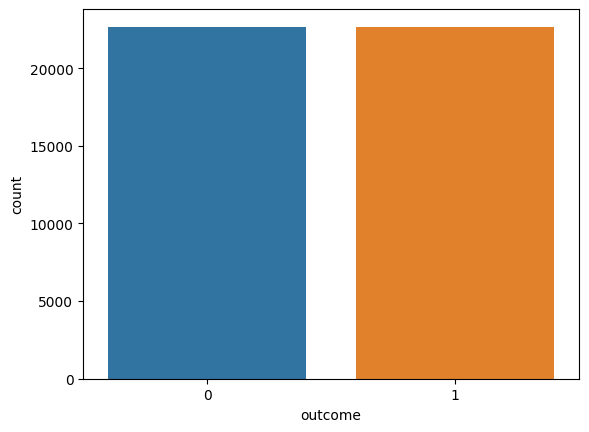

In [91]:
sns.countplot(x='outcome',hue='outcome',data=loan_data,legend=False)
loan_data['outcome'].value_counts(normalize=True) * 100

In [80]:
loan_data.columns

Index(['status', 'loan_amnt', 'term', 'annual_inc', 'dti', 'payment_inc_ratio',
       'revol_bal', 'revol_util', 'purpose', 'home_ownership',
       'delinq_2yrs_zero', 'pub_rec_zero', 'open_acc', 'grade', 'outcome',
       'emp_length', 'purpose_', 'home_', 'emp_len_', 'borrower_score'],
      dtype='object')

In [ ]:
# Definicion de las variables numéricas
num_variables = ['loan_amnt','annual_inc','payment_inc_ratio','dti','revol_bal','revol_util','borrower_score']

In [ ]:
# Definicion de las variables categóricas
cat_variables = ['home_','emp_len_','purpose_']

for col in cat_variables:
    loan_data[col] = loan_data[col].astype('category')

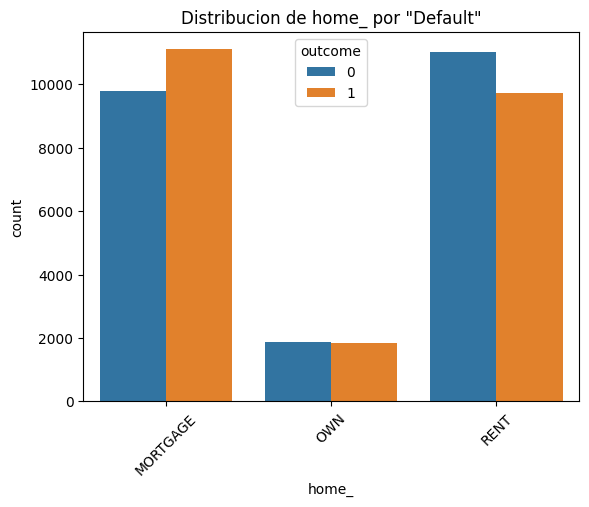

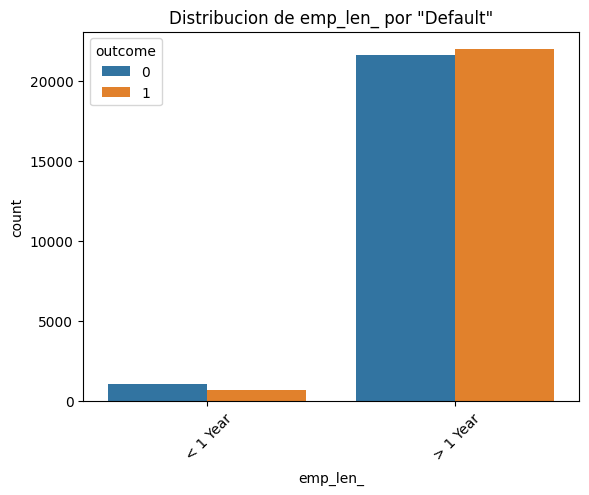

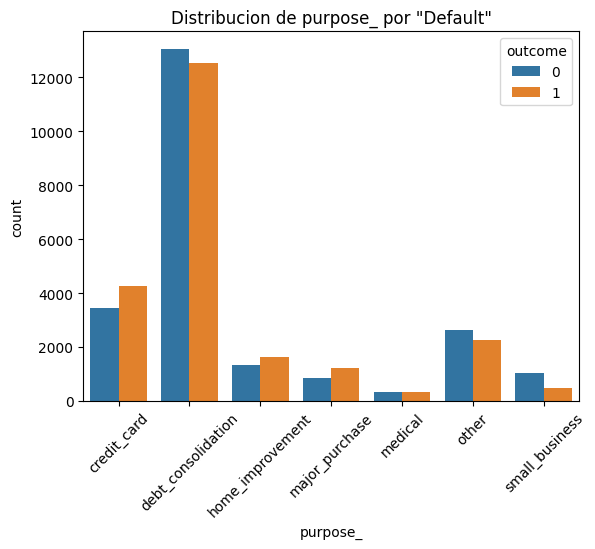

In [93]:
for col in cat_variables:
    sns.countplot(x=col,data=loan_data, hue='outcome')
    plt.title(f'Distribucion de {col} por "Default"')
    plt.xticks(rotation=45)
    plt.show()

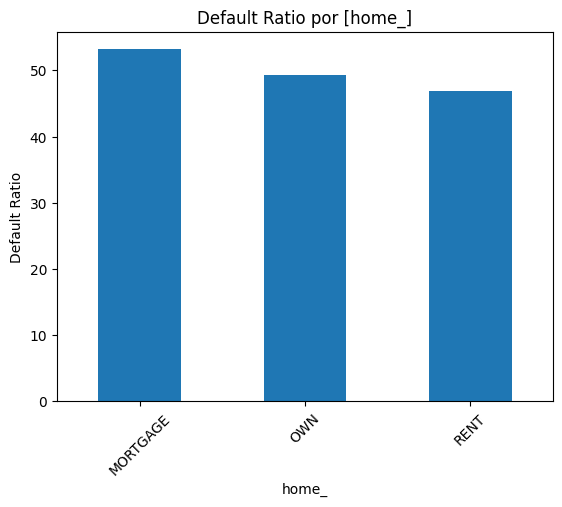

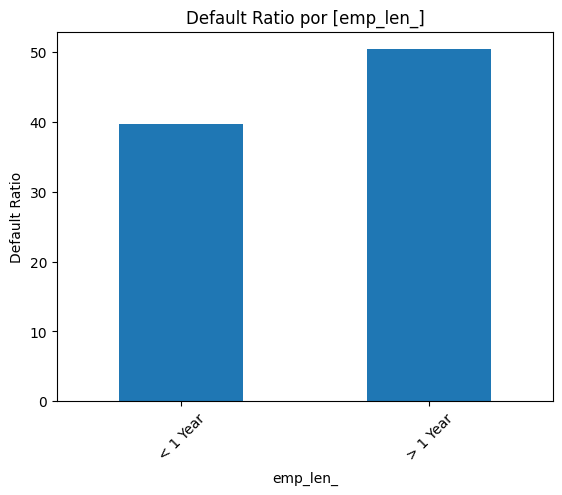

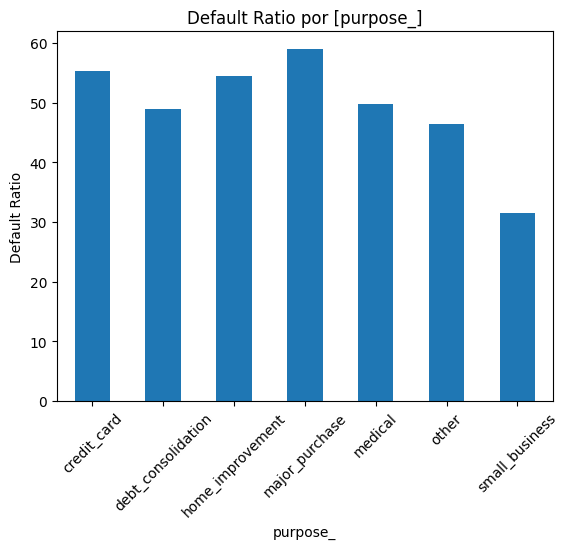

In [ ]:
# El ratio de Default por cada categoria
for col in cat_variables:
    default_ratio = loan_data.groupby(col,observed=True)['outcome'].mean() * 100
    default_ratio.plot(kind='bar')
    plt.title(f'Default Ratio por [{col}]')
    plt.ylabel('Default Ratio')
    plt.xticks(rotation=45)
    plt.show()

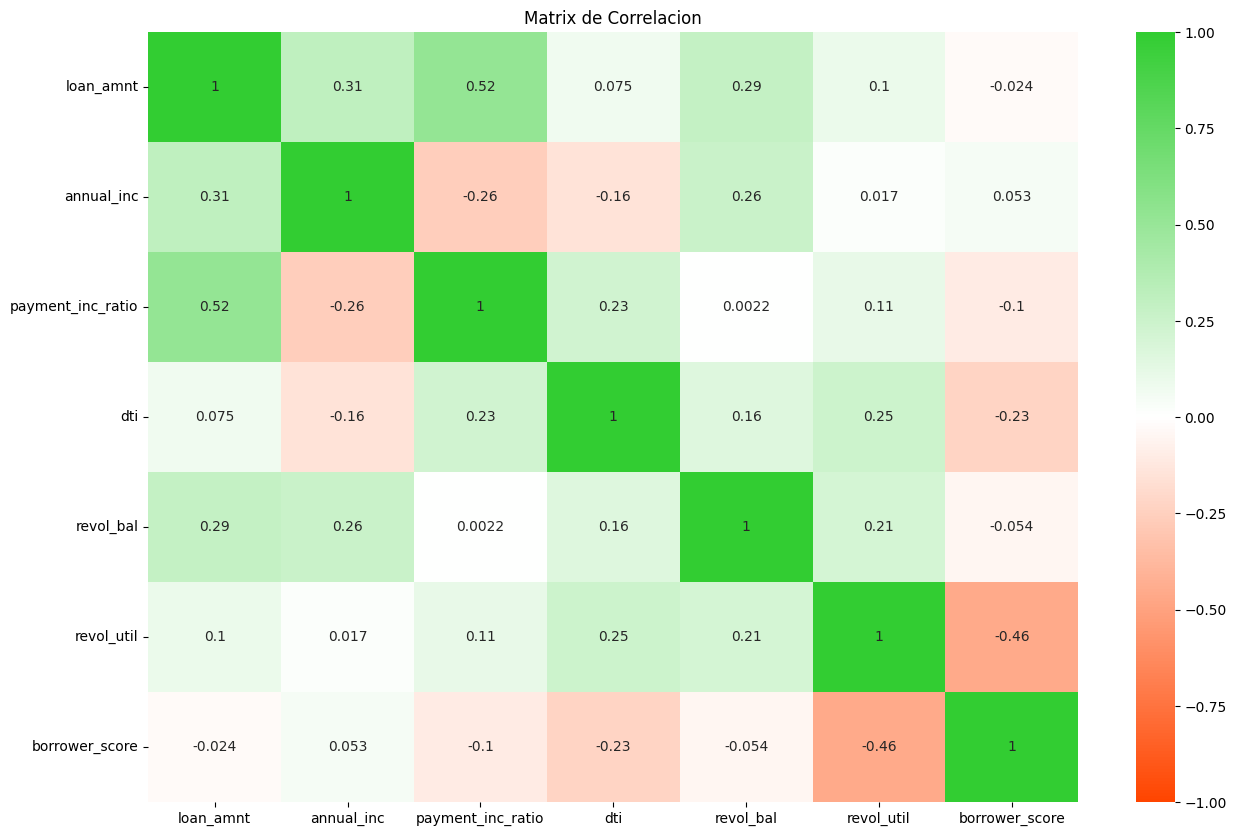

In [103]:
from matplotlib.colors import LinearSegmentedColormap
orange_green_cmap = LinearSegmentedColormap.from_list("OrangeGreen", ['#ff4500', '#FFFFFF', '#32CD32'])

plt.figure(figsize=(15,10))
corr = loan_data[num_variables].corr()
sns.heatmap(corr, cmap=orange_green_cmap, annot=True, center=0, vmin=-1, vmax=1)
plt.title('Matrix de Correlacion')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()



**Cantidad por Objetivo/Proposito del préstamo** (`purpose_`)

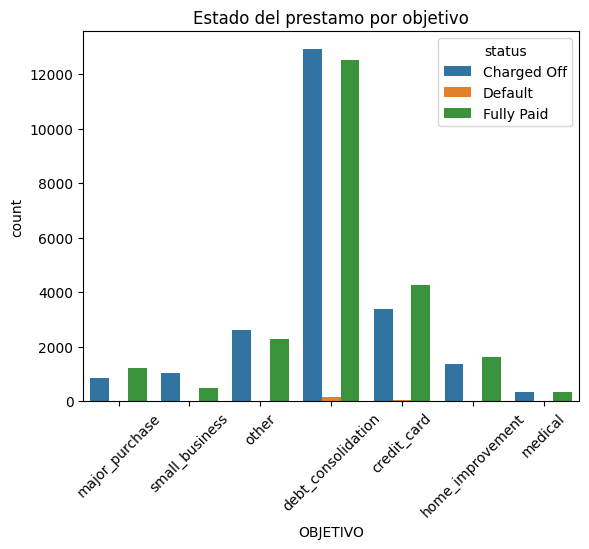

In [136]:
sns.countplot(x='purpose_',hue='status',data=loan_data).set_title('Estado del prestamo por objetivo')
plt.xticks(rotation=45)
plt.xlabel('OBJETIVO')
plt.show()

El gráfico nos muestra que la mayoría de personas pide préstamos con el propósito de consolidar sus deudas. Además se observa que muchos de los préstamos tiene un número similar de cantidad de préstamos pagados y no pagados.

Text(0.5, 1.0, 'Cantidad de prestamos por tipo de vivienda')

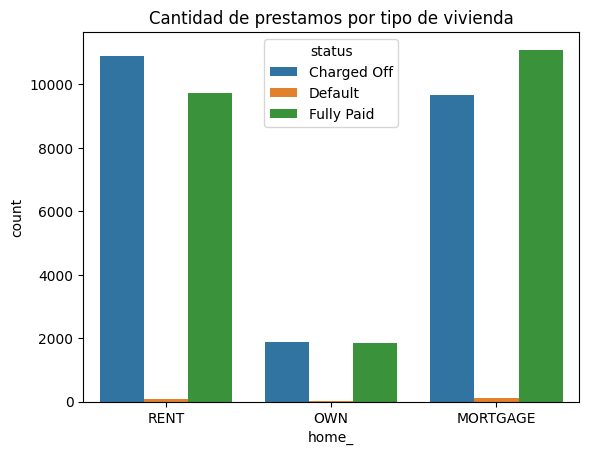

In [33]:
sns.countplot(x='home_',hue='status',data=loan_data).set_title('Cantidad de prestamos por tipo de vivienda')
# plt.xticks(rotation=90)

Al igual que en la gráfica anterior, observamos que tenemos un número similar de deudas pagadas y no pagadas con respecto al tipo de vivienda del cliente. Tambien las personas que aún están pagando sus hipotecas tienden ligeramente a ser más cumplidos con el pago del préstamo.

# PROCESAMIENTO DE LA DATA

USANDO XGBoost

In [109]:
# Se define los features que seran usados para el modelo
predictores = cat_variables+num_variables
X = loan_data[predictores]
y = loan_data['outcome']

X.head()

,home_,emp_len_,purpose_,loan_amnt,annual_inc,payment_inc_ratio,dti,revol_bal,revol_util,borrower_score
0,RENT,> 1 Year,major_purchase,2500,30000,2.39320,1.00,1687,9.4,0.65
1,OWN,> 1 Year,small_business,5600,40000,4.57170,5.55,5210,32.6,0.80
2,RENT,> 1 Year,other,5375,15000,9.71600,18.08,9279,36.5,0.60
3,RENT,> 1 Year,debt_consolidation,9000,30000,12.21520,10.08,10452,91.7,0.50
4,RENT,> 1 Year,other,10000,100000,3.90888,7.06,11997,55.5,0.55


In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2,stratify=y, random_state=1)

In [111]:
# Se establece el Pipeline
estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=1,objective='binary:logistic'))
    ]
mi_pipe = Pipeline(steps=estimators)
print(mi_pipe)

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                             

In [112]:
# afinando los hyperparametros de XGBoost para obtener mejores resultado del modelo
params_space = {
    'clf__max_depth': Integer(2,8),
    'clf__n_estimators': Integer(1, 250),
    'clf__learning_rate': Real(0.001,1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5,1.0),
    'clf__colsample_bylevel':Real(0.5, 1.0),
    'clf__colsample_bynode': Real(0.5,1.0),
    'clf__reg_alpha': Real(0.0,10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

model_tuned = BayesSearchCV(mi_pipe, params_space, cv=3, n_iter=10, scoring='roc_auc',random_state=1)



In [113]:
model_tuned.fit(X_train,y_train)

,estimator,"Pipeline(step...=None, ...))])"
,search_spaces,"{'clf__colsample_bylevel': Real(low=0.5,...m='normalize'), 'clf__colsample_bynode': Real(low=0.5,...m='normalize'), 'clf__colsample_bytree': Real(low=0.5,...m='normalize'), 'clf__gamma': Real(low=0.0,...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,10
,scoring,'roc_auc'
,fit_params,None
,n_jobs,1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,3


In [114]:
print(model_tuned.best_estimator_)

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['home_', 'emp_len_', 'purpose_'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.9837828982141709,
                               colsample_bynode=0.7157293897471988,
                               colsample_bytree=0.7989222031658678, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=N...
                               gamma=1.9801949495486166, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.07628548284717386, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=N

In [115]:
model_tuned.best_score_

np.float64(0.7019752388201802)

In [134]:
model_tuned.score(X_train,y_train)

0.707766976734616

In [128]:
xgb_pred = model_tuned.predict(X_test)
xgb_pred 

array([1, 1, 0, ..., 0, 0, 0], shape=(9069,))

In [118]:
model_tuned.predict_proba(X_test)

array([[0.46056092, 0.5394391 ],
       [0.4031772 , 0.5968228 ],
       [0.7187013 , 0.2812987 ],
       ...,
       [0.6161905 , 0.3838095 ],
       [0.572875  , 0.42712498],
       [0.88369083, 0.11630914]], shape=(9069, 2), dtype=float32)

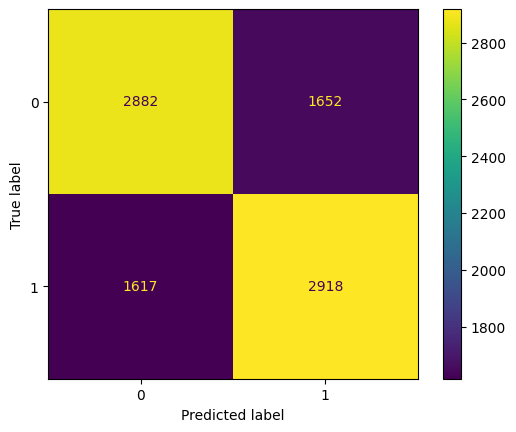

In [119]:
# confusion matrix
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
cm = confusion_matrix(y_test, model_tuned.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_tuned.classes_)
disp.plot()
plt.show()


# USANDO RANDOM FOREST

In [123]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import oneHotEncoder
# rfc = RandomForestClassifier()

In [125]:
estimators_rfc = [
    ('encoder', TargetEncoder()),
    ('rfc', RandomForestClassifier(random_state=1))
    ]
mi_pipe = Pipeline(steps=estimators_rfc)
print(mi_pipe)


Pipeline(steps=[('encoder', TargetEncoder()),
                ('rfc', RandomForestClassifier(random_state=1))])


In [126]:
mi_pipe.fit(X_train,y_train)

,steps,"[('encoder', ...), ('rfc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,"['home_', 'emp_len_', ...]"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20


In [127]:
mi_pipe.score(X_test,y_test)

0.6334766787958981

In [130]:
rf_predict = mi_pipe.predict(X_test)

In [135]:
from sklearn.metrics import classification_report
print('XGBOOST')
print(classification_report(y_test, xgb_pred))
print('RANDOM FOREST')
print(classification_report(y_test, rf_predict))

XGBOOST
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      4534
           1       0.64      0.64      0.64      4535

    accuracy                           0.64      9069
   macro avg       0.64      0.64      0.64      9069
weighted avg       0.64      0.64      0.64      9069

RANDOM FOREST
              precision    recall  f1-score   support

           0       0.63      0.64      0.64      4534
           1       0.64      0.62      0.63      4535

    accuracy                           0.63      9069
   macro avg       0.63      0.63      0.63      9069
weighted avg       0.63      0.63      0.63      9069



# CONCLUSIÓN

De acuerdo a las métricas usadas, el modelo XGBoost da 64% de predicción acertada para conoicer si el préstamo será pagado o no.
Es posible incrementar el porcetage de predicción ajustando los hyperparámetros del modelo usando `GridSearchCV`, para fines del ejemplo no se usó debido a que la ejecución toma bastante tiempo (días)